# Modeling Notebooks
- Loads in cleaned and engineered features
- Trains and evaluates several modeling options
- Performs model selection

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet, lasso_path
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm

pd.set_option("display.max_columns", None)

In [50]:
output_path = Path("../outputs")
figure_path = Path("../figures")

# train/val/test splits
splits = (0.70, 0.15, 0.15)
seed = 598

In [10]:
# load in features
df = pd.read_csv("../data/bitcoin_features.csv", parse_dates=["Date"])
df = df.sort_values("Date").reset_index(drop=True)

In [40]:
target_col = "target_t7"
# exclude Date and target
exclude = {"Date", target_col}

# create X and y
X = df[[c for c in df.columns if c not in exclude]].astype(float).copy()
y = df[target_col].copy()

# save variables for later use
feature_names = X.columns.tolist()
date_index = df["Date"].copy()
price_t = df["btc_market_price"].copy()

In [42]:
# create chronological 70/15/15 train/val/test splits
n = len(df)
n_train = int(splits[0] * n)
n_val = int(splits[1] * n)
train_idx = slice(0, n_train)
val_idx = slice(n_train, n_train + n_val)
test_idx = slice(n_train + n_val, n)

# create datasets
X_train, y_train = X.iloc[train_idx].copy(), y.iloc[train_idx].copy()
X_val, y_val = X.iloc[val_idx].copy(), y.iloc[val_idx].copy()
X_test, y_test = X.iloc[test_idx].copy(), y.iloc[test_idx].copy()

# keep track of dates and prices in each set
dates_train = date_index.iloc[train_idx].reset_index(drop=True)
dates_val = date_index.iloc[val_idx].reset_index(drop=True)
dates_test = date_index.iloc[test_idx].reset_index(drop=True)
price_t_train = price_t.iloc[train_idx].reset_index(drop=True)
price_t_val = price_t.iloc[val_idx].reset_index(drop=True)
price_t_test = price_t.iloc[test_idx].reset_index(drop=True)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (1895, 43), Val: (406, 43), Test: (407, 43)


In [44]:
# metric helper functions for evaluation
def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

def mae(y_true, y_pred):
    return float(mean_absolute_error(y_true, y_pred))

def r2(y_true, y_pred):
    return float(r2_score(y_true, y_pred))

In [46]:
# fit OLS just for baseline diagnostics
X_train_const = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_train_const).fit()

ols_adj_r2 = float(ols_model.rsquared_adj)
ols_aic = float(ols_model.aic)
ols_bic = float(ols_model.bic)

print("OLS (training) Adj R²:", ols_adj_r2)
print("OLS (training) AIC:", ols_aic)
print("OLS (training) BIC:", ols_bic)

with open(output_path / "ols_summary.txt", "w") as f:
    f.write(ols_model.summary().as_text())

OLS (training) Adj R²: 0.9717759582995326
OLS (training) AIC: 19270.523417153538
OLS (training) BIC: 19514.590278324264


In [48]:
# pipelines and hyperparameter grids for ridge and lass
tscv = TimeSeriesSplit(n_splits=5)

ridge_pipe = Pipeline([("scaler", StandardScaler()), ("model", Ridge(random_state=seed))])
lasso_pipe = Pipeline([("scaler", StandardScaler()), ("model", Lasso(max_iter=20000, random_state=seed))])
enet_pipe  = Pipeline([("scaler", StandardScaler()), ("model", ElasticNet(max_iter=20000, random_state=seed))])

alphas = np.logspace(-4, 3, 25)

ridge_grid = {"model__alpha": alphas}
lasso_grid = {"model__alpha": alphas}
enet_grid  = {"model__alpha": alphas, "model__l1_ratio": [0.2, 0.5, 0.8]}

In [54]:
# tuning hyperparameters on training data
def ts_grid_search(pipe, grid, X_tr, y_tr, cv, name):
    gs = GridSearchCV(estimator=pipe,param_grid=grid,
                      scoring="neg_root_mean_squared_error",
                      cv=cv, n_jobs=-1, refit=True, verbose=0,
                      return_train_score=True)
    gs.fit(X_tr, y_tr)
    cv_res = pd.DataFrame(gs.cv_results_)
    cv_res.to_csv(output_path / f"cv_results_{name}.csv", index=False)
    return gs, cv_res

gs_ridge, cv_ridge = ts_grid_search(ridge_pipe, ridge_grid, X_train, y_train, tscv, "ridge")
gs_lasso, cv_lasso = ts_grid_search(lasso_pipe, lasso_grid, X_train, y_train, tscv, "lasso")
gs_enet,  cv_enet  = ts_grid_search(enet_pipe,  enet_grid,  X_train, y_train, tscv, "elasticnet")


best_ridge = gs_ridge.best_estimator_
best_lasso = gs_lasso.best_estimator_
best_enet  = gs_enet.best_estimator_

print("Best Ridge:", gs_ridge.best_params_, "CV RMSE:", round(-gs_ridge.best_score_, 4))
print("Best LASSO:", gs_lasso.best_params_, "CV RMSE:", round(-gs_lasso.best_score_, 4))
print("Best ENet :", gs_enet.best_params_,  "CV RMSE:", round(-gs_enet.best_score_, 4))

Best Ridge: {'model__alpha': 1000.0} CV RMSE: 396.9122
Best LASSO: {'model__alpha': 9.08517575651688} CV RMSE: 57.0063
Best ENet : {'model__alpha': 34.80700588428413, 'model__l1_ratio': 0.2} CV RMSE: 103.4351


In [58]:
# validation evaluation
def eval_on_split(estimator, Xp, yp, price_current, split_name):
    yp_hat = estimator.predict(Xp)
    return {"split": split_name, "rmse": rmse(yp, yp_hat),
            "mae": mae(yp, yp_hat), "r2": r2(yp, yp_hat)}

val_results = []
for name, est in [("ridge", best_ridge), ("lasso", best_lasso), ("elasticnet", best_enet)]:
    metrics = eval_on_split(est, X_val, y_val, price_t_val, f"val_{name}")
    val_results.append((name, metrics))

val_df = pd.DataFrame([{"model": n, **m} for n, m in val_results]).sort_values("rmse")
val_df.to_csv(output_path / "val_metrics.csv", index=False)
val_df

,model,split,rmse,mae,r2
1,lasso,val_lasso,56.342763,42.710981,0.859549
0,ridge,val_ridge,108.807106,87.268830,0.476204
2,elasticnet,val_elasticnet,280.505360,254.778666,-2.481205


In [62]:
# choose best model by lowest validation RMSE
optimal = val_df.iloc[0]["model"]
print("Selected finalist:", optimal)

Selected finalist: lasso


In [74]:
# get final Lasso object
lasso_model = best_lasso.named_steps["model"]

# get coefficients
coefs = lasso_model.coef_

selected_features = pd.DataFrame({"feature": feature_names,
                                  "coef": coefs})

# filter to nonzero features
selected_features = selected_features[selected_features["coef"] != 0]

# sort by importance
selected_features = selected_features.reindex(selected_features.coef.abs().sort_values(ascending=False).index)

display(selected_features)
selected_features.to_csv(output_path / "lasso_selected_features.csv", index=False)

,feature,coef
0,btc_market_price,246.431894
9,btc_n_transactions,3.002408
19,btc_market_price_std7,0.251648
39,btc_trade_volume_log,0.062772


In [64]:
# refit on train/val and evaluate on test
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)
price_t_trval = pd.concat([price_t_train, price_t_val], axis=0)
dates_trval = pd.concat([dates_train, dates_val], axis=0)

best_lasso.fit(X_trval, y_trval)

# evaluate
test_pred = best_lasso.predict(X_test)
test_metrics = {"split": "test_" + optimal,
                "rmse": rmse(y_test, test_pred),
                "mae": mae(y_test, test_pred),
                "r2": r2(y_test, test_pred)}
pd.DataFrame([test_metrics]).to_csv(output_path / "test_metrics.csv", index=False)
test_metrics

{'split': 'test_lasso',
 'rmse': 1286.252225903387,
 'mae': 713.5398971962578,
 'r2': 0.922193255376981}

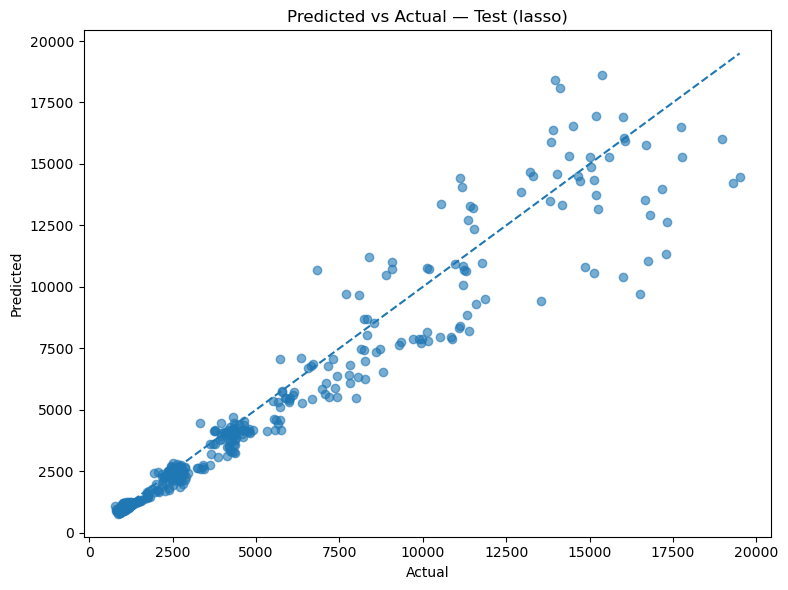

In [66]:
# plots for best model
yhat_test = test_pred
resid_test = y_test - yhat_test

# predicted vs actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, yhat_test, alpha=0.6)
miny, maxy = min(y_test.min(), yhat_test.min()), max(y_test.max(), yhat_test.max())
plt.plot([miny, maxy], [miny, maxy], linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Predicted vs Actual — Test ({optimal})")
plt.tight_layout()
plt.savefig(figure_path / f"pred_vs_actual_test_{optimal}.png", dpi=150)
plt.show()

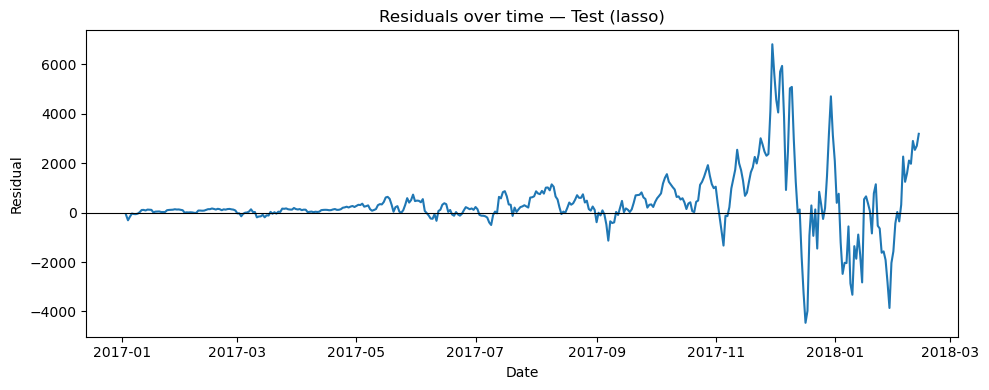

In [70]:
# residuals over time
plt.figure(figsize=(10,4))
plt.plot(dates_test, resid_test)
plt.axhline(0, color="k", linewidth=0.8)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title(f"Residuals over time — Test ({optimal})")
plt.tight_layout()
plt.savefig(figure_path / f"residuals_over_time_test_{optimal}.png", dpi=150)
plt.show()

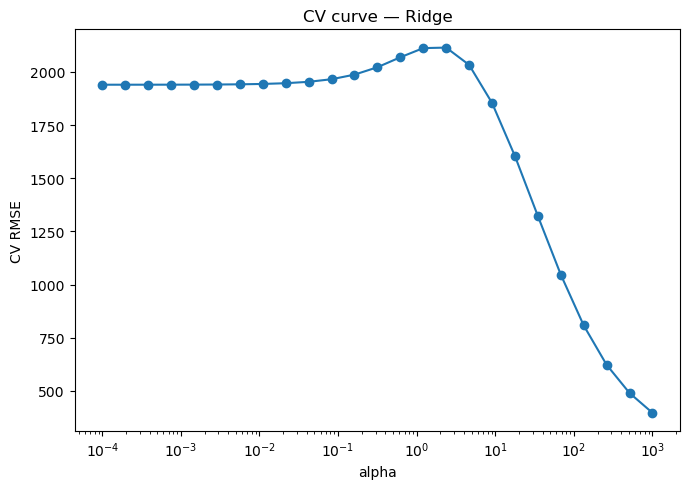

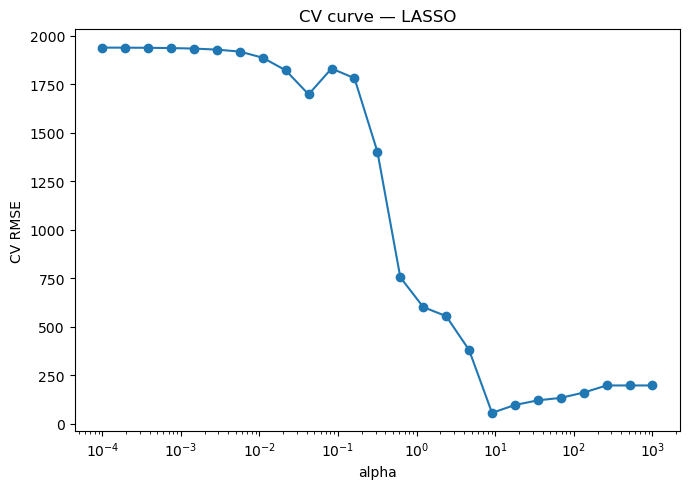

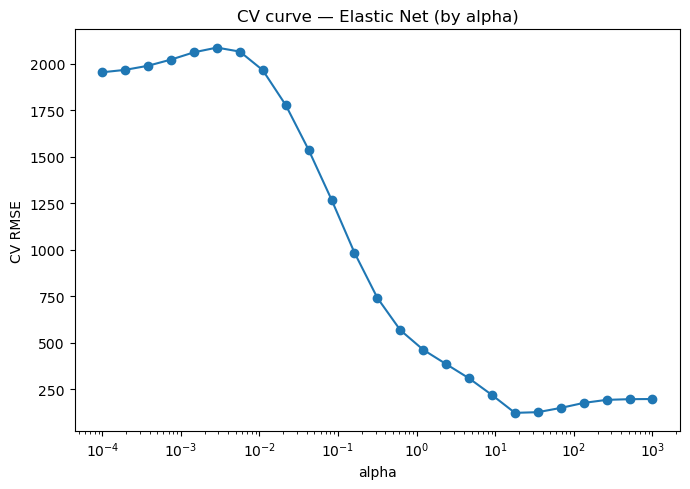

In [72]:
# plot CV curves and coefficients
def plot_cv_curve(cv_df, param_col, label, out_name):
    dfp = cv_df.copy()
    if param_col not in dfp.columns:
        return
    dfp["rmse"] = -dfp["mean_test_score"]
    grouped = dfp.groupby(param_col)["rmse"].mean().sort_index()
    plt.figure(figsize=(7,5))
    plt.plot(grouped.index, grouped.values, marker="o")
    plt.xscale("log")
    plt.xlabel(param_col.replace("param_model__", ""))
    plt.ylabel("CV RMSE")
    plt.title(f"CV curve — {label}")
    plt.tight_layout()
    plt.savefig(figure_path / out_name, dpi=150)
    plt.show()

plot_cv_curve(cv_ridge, "param_model__alpha", "Ridge", "cv_curve_ridge.png")
plot_cv_curve(cv_lasso, "param_model__alpha", "LASSO", "cv_curve_lasso.png")
plot_cv_curve(cv_enet,  "param_model__alpha", "Elastic Net (by alpha)", "cv_curve_enet_alpha.png")